### Intro
- LSTM are tricky to get them to work

In [0]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


In [5]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# Refer: https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words = top_words)


/usr/local/lib/python3.6/dist-packages/keras/datasets/imdb.py:49: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '


17465344/17464789 [==============================] - 3s 0us/step


In [6]:
print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))
print("-------------------")
print(X_train.shape)

[1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369, 2, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 2, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 2, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 2, 2, 349, 2637, 148, 605, 2, 2, 15, 123, 125, 68, 2, 2, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 2, 5, 2, 656, 245, 2350, 5, 4, 2, 131, 152, 491, 18, 2, 32, 2, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
<class 'list'>
189
-------------------
(25000,)


### Knowing the IMDB keras data
- 50K data of reviews
- each review is sequence of words
    - x1 = x11,x22... and yi
       
- First build V = a set or corpus of all the words in all the review
    1. for each word compute frequency of the word
    2. sort by fequency
        - ex
            - The = 50K
            - a = 40K
    3. give Rank to the words, ex. Whenever we see The replace with 1, whenever we see 'a' replace it with 2
        - .'. 1 is for most freq words and we will take top 5000 words.
        - let a review has a word having rank 5001, discard that word
        
- let say we have x1= x11,x12...x1,189
- x2 = x21,x22,..,x290
- so we have words of diff length
    - So we will add padding
    - so it will convert all x1 to 600 length
    - this does prepadding, ie. 0 before and data after till it is 600 dimensional
- if review has > 600 words, discard more than 600



In [7]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(25000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

why pad ?
- we use RNN and LSTM bcz we can have different length inputs. But we are we doing padding here 
    - ex. let x1 = x11,x12,....x1 189
    - x2 = x21,x22,....x2 200
    - x3 = x31,x32,....x3 150
- initially we will send x1 to the nodes, then x2 and then x3 in every time sequence.
    - this is like SGD with batch size 1 which is too slow
    - ie. x11 to 1st node , x12 to 2nd node .....
- lets say,we perform sgd with batch size =5. 
    - here x11,x21,x31,x41,x51 to 1st node
    - x12,x22,x32,x42,x52 to 2nd node
    - to perform batch update we need each of sequence to have same length. 
- So padding allows batch operation and faster training
- For text, we will generally do padding.

#### Create model
- 1st layer is embedding layer
    - Embedding layer takes indices and returns vectors
    - they are used a lot in nlp tasks
    - for each of our word in review we can represent using 5000-dim one hot encoded vector
        - word2vec is an example of embedding
        - so it will take a word and give a vector representation of the word
    - why to do embedding and not w2v?
        - for every word we have static word2vec and we are not learning as per task
    - params
        - input - 5000
        - output - 32
        - .'. num of params 160K
        - it has 32 activations so we wil get 32 output

- LSTM (100) means we have 100 LSTMs
    - each of LSTM takes the same 32 dim vector
    - each of LSTM generate output
    - each LSTM takes 32 dim input gives o/p and has a feedback loop
    - params :
        - m = 32 inputs and 100 outputs and each giving scalar
        - n = total o/p size 100
        - #params = 4( nm + n^2 + n)
            - last n is for bias
            - lstm in keras has by default bias terms
            - = 53200
- now connect all 100 + 1 bias term to a signmoid to get yi^ which is binary
    - params : 101
- loss is binary cross entropy

In [8]:
# create the model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
25000/25000 [==============================] - 754s 30ms/step - loss: 0.2870 - acc: 0.8859
Epoch 2/10
20096/25000 [=======================>......] - ETA: 2:27 - loss: 0.2296 - acc: 0.9102

25000/25000 [==============================] - 754s 30ms/step - loss: 0.2302 - acc: 0.9098
Epoch 3/10
25000/25000 [==============================] - 753s 30ms/step - loss: 0.2481 - acc: 0.9004
Epoch 4/10
 4352/25000 [====>.........................] - ETA: 10:19 - loss: 0.1734 - acc: 0.9373

25000/25000 [==============================] - 752s 30ms/step - loss: 0.1816 - acc: 0.9323
Epoch 5/10
24704/25000 [============================>.] - ETA: 8s - loss: 0.1487 - acc: 0.9454 

25000/25000 [==============================] - 753s 30ms/step - loss: 0.1488 - acc: 0.9453
Epoch 6/10
25000/25000 [==============================] - 749s 30ms/step - loss: 0.1414 - acc: 0.9486
Epoch 7/10
 5696/25000 [=====>........................] - ETA: 9:36 - loss: 0.1036 - acc: 0.9628

25000/25000 [==============================] - 751s 30ms/step - loss: 0.1171 - acc: 0.9589
Epoch 8/10
25000/25000 [==============================] - 755s 30ms/step - loss: 0.2678 - acc: 0.8851
Epoch 9/10
  128/25000 [..............................] - ETA: 12:20 - loss: 0.4913 - acc: 0.7344

25000/25000 [==============================] - 756s 30ms/step - loss: 0.3090 - acc: 0.8634
Epoch 10/10
22656/25000 [==========================>...] - ETA: 1:10 - loss: 0.1614 - acc: 0.9378

25000/25000 [==============================] - 750s 30ms/step - loss: 0.1617 - acc: 0.9380
Accuracy: 86.09%


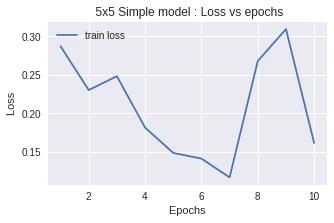

In [17]:
epochs_list = list(range(1,11))
import matplotlib.pyplot as plt
train_acc = history.history['acc']
train_loss = history.history['loss']

plt.figure(figsize=(5,3))
plt.plot(epochs_list,train_loss,label="train loss")
plt.xlabel(" Epochs ")
plt.ylabel(" Loss ")
plt.legend()
plt.title(" 5x5 Simple model : Loss vs epochs")
plt.show()

In [16]:
history.history.keys()

dict_keys(['loss', 'acc'])

Note: Each LSTM cell may learn something diff in data